# Analizador y bonos y carteras

Objetivo:
Crear clases de Python que realicen diferentes análisis a bonos permitiendo visualizar los
resultados, administrar el riesgo y evaluar el desempeño de la inversión

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [ ]:
'''Funcion para calcular la IRR optima'''

def calcular_irr_optima(data, irr_inicial):
  # Función para calcular la suma acumulada de PV_IRR
  def suma_acumulada_pv_irr(irr_inicial):
       pv_irr = data['Pago'] / ((1 + irr_inicial) ** data['t'])
       return np.sum(pv_irr)

  # Función objetivo para fsolve
  def objetivo(irr_inicial):
       suma_pv_irr = suma_acumulada_pv_irr(irr_inicial)
       suma_pv = np.sum(data['PV'])
       return suma_pv_irr - suma_pv

  # Uso de fsolve para encontrar la IRR que hace que la diferencia sea cero
  irr_optima = fsolve(objetivo, irr_inicial)
  irr_optima_n = irr_optima[0]

  return irr_optima_n

In [ ]:
class Bonos:

  '''Metodo constructor'''
  def __init__(self, fecha_emision, fecha_expiracion, periodicidad, tasa_cupon):
      self.fecha_emision = fecha_emision
      self.fecha_expiracion = fecha_expiracion
      self.periodicidad = periodicidad
      self.tasa_cupon = tasa_cupon
      self.principal = 100000
      self.flujos = self.crea_df()

  '''Metodo que crea el flujo de caja'''
  def crea_df(self):

      'Calculo de los dias entre las dos fechas'
      fecha_emision_f = datetime.strptime(self.fecha_emision,'%Y-%m-%d')
      fecha_expiracion_f = datetime.strptime(self.fecha_expiracion,'%Y-%m-%d')
      dias = (fecha_expiracion_f - fecha_emision_f).days
      dias_f = float(dias)
      num_pagos_f = dias_f / (365/self.periodicidad)
      num_pagos = int(num_pagos_f)

      'Calculo de la lista de fechas y pagos'
      pagos = (self.principal * self.tasa_cupon)/ self.periodicidad
      fechas = fecha_emision_f
      data = []

      for i in range(0,num_pagos):
         if i==0:
            fechas = fechas + timedelta(days= dias_f/num_pagos_f)
            data.append([fechas,pagos])
         elif i==num_pagos-1:
            fechas = fecha_expiracion_f
            pagos = pagos + self.principal
            data.append([fechas,pagos])
         else:
            fechas = fechas + timedelta(days=dias_f/num_pagos_f)
            data.append([fechas,pagos])

      data_f = pd.DataFrame(data, columns=['Fecha', 'Pago'])

      return data_f


  '''Metodo que calcula la curva de rendimientos del modelo Nelson_Siegel'''
  def Nelson_Siegel(self, fecha_valoracion, parametros, plazos=None):

      fecha_valoracion = fecha_valoracion
      parametros = parametros
      B_0, B_1, B_2, d = parametros
      plazos = plazos
      print("Fecha de valoración",fecha_valoracion)
      if plazos is None:
        plazos = [0.25, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
        tasas = []
        for plazo in plazos:
          dxt = plazo * d
          exp_dxt = np.exp(-dxt)
          tasa = B_0 + B_1 * (1 - exp_dxt) / dxt + B_2 * ((1 - exp_dxt) / dxt - exp_dxt)
          tasas.append(tasa)
        plt.figure(figsize=(25, 6))
        plt.plot(plazos, tasas)
        plt.xlabel('Plazo (años)')
        plt.ylabel('Tasa de retorno (%)')
        plt.title('Curva de rendimiento Nelson-Siegel')
        plt.grid(True)
        plt.xticks(plazos)
        plt.ylim(0.0, 0.12)
        plt.show()
      else:
        dxt = plazos * d
        exp_dxt = np.exp(-dxt)
        tasa = B_0 + B_1 * (1 - exp_dxt) / dxt + B_2 * ((1 - exp_dxt) / dxt - exp_dxt)
        print("Tasa para el plazo", plazos, ":", "{:.2%}".format(tasa))
        return tasa


  '''Metodo que valora el bono y calcula metricas'''
  def valoracion(self, fecha_negociacion, parametros):

      'Validacion de fecha de negociacion correcta'
      if fecha_negociacion > self.fecha_emision and fecha_negociacion < self.fecha_expiracion:
        fecha_negociacion_f = datetime.strptime(fecha_negociacion,'%Y-%m-%d')
        data = self.crea_df()
        data['Plazo_dias'] = 0
        data['t'] = 0
        data['r'] = 0
        data['PV'] = 0
        data['IRR'] = 0.05
        data['PV_IRR'] = 0
        for i in range(len(data)):
            data.loc[i, 'Plazo_dias'] = (data.loc[i, 'Fecha'] - fecha_negociacion_f).days
            if data.loc[i, 'Plazo_dias'] < 0:
              data.loc[i,'Pago'] = 0
            data.loc[i, 't'] = data.loc[i, 'Plazo_dias'] / 365
            data.loc[i, 'r'] = self.Nelson_Siegel(fecha_negociacion, parametros, data.loc[i, 't'])
            data.loc[i, 'PV'] = data.loc[i, 'Pago'] / (1+data.loc[i, 'r'])**data.loc[i, 't']
            data.loc[i, 'PV_IRR'] =  data.loc[i, 'Pago'] / ((1+data.loc[i,'IRR'])**data.loc[i, 't'])

        # Calcular la IRR óptima con la funcion creada
        irr_prueba = 0.05
        irr_optima_n = calcular_irr_optima(data, irr_prueba)
        data['IRR'] = irr_optima_n

        for i in range(len(data)):
            data.loc[i, 'PV_IRR'] =  data.loc[i, 'Pago'] / ((1+data.loc[i,'IRR'])**data.loc[i, 't'])

        # Calculo de metricas
        PV_Acumulado = data['PV'].sum()
        PV_IRR_Acumulado = data['PV_IRR'].sum()

        data['Duracion'] = 0
        data['Convexidad'] = 0

        for i in range(len(data)):
            data.loc[i, 'Duracion'] = (data.loc[i, 't']/PV_IRR_Acumulado) * data.loc[i, 'PV_IRR']
            data.loc[i, 'Convexidad'] = data.loc[i, 't'] * (1 + data.loc[i, 't']) * data.loc[i, 'PV_IRR']

        duracion_Acumulado = data['Duracion'].sum()
        Convexidad_Acumulado = data['Convexidad'].sum()

        for i in range(len(data)):
            if fecha_negociacion_f < data.loc[i, 'Fecha']:
               fecha_calculo = data.loc[i-1, 'Fecha']
               break
        tiempo_ultimo_pago = ((fecha_negociacion_f - fecha_calculo).days)/365
        tiempo_entre_pagos = ((data.loc[1, 'Fecha']-data.loc[0, 'Fecha']).days)/365
        intereses_causados = (tiempo_ultimo_pago/tiempo_entre_pagos)*data.iloc[-2, 1]
        precio_sucio = PV_Acumulado
        precio_limpio = precio_sucio - intereses_causados
        Tasa_rendimiento = data.loc[0,'IRR']
        Duracion_modificada = duracion_Acumulado/(1+Tasa_rendimiento)
        convexidad = Convexidad_Acumulado/((1+Tasa_rendimiento)**2)

        Metricas = {'Precio_sucio':precio_sucio,
                    'Precio_limpio': precio_limpio,
                    'Intereses_Causados': intereses_causados,
                    'Tasa_Rendimiento': Tasa_rendimiento,
                    'Duracion_Modicifada': Duracion_modificada,
                    'Convexidad': convexidad,
                    'Suma_pagos': data['Pago'].sum()}
        return Metricas

      else:
        print('Fecha de negociacion invalida')


  '''Metodo que calcula el retorno del bono a una fecha'''
  def retorno(self, fecha_compra, fecha_de_valoracion, parametros_compra, parametros_valoracion):

   if fecha_compra > self.fecha_emision and fecha_compra < self.fecha_expiracion:
     if fecha_de_valoracion > fecha_compra and fecha_de_valoracion < self.fecha_expiracion:
      fecha_de_valoracion_f =  datetime.strptime(fecha_de_valoracion,'%Y-%m-%d')
      fecha_compra_f =  datetime.strptime(fecha_compra,'%Y-%m-%d')
      data = self.crea_df()
      data['Plazo_dias'] = 0
      data['t'] = 0
      data['r'] = 0
      data['PV'] = 0
      data['IRR'] = 0.05
      data['PV_IRR'] = 0

      for i in range(len(data)):
          data.loc[i, 'Plazo_dias'] = (data.loc[i, 'Fecha'] - fecha_de_valoracion_f).days
          if data.loc[i, 'Plazo_dias'] < 0:
             data.loc[i,'Pago'] = 0
          data.loc[i, 't'] = data.loc[i, 'Plazo_dias'] / 365
          data.loc[i, 'r'] = self.Nelson_Siegel(fecha_de_valoracion_f, parametros_valoracion, data.loc[i, 't'])
          data.loc[i, 'PV'] = data.loc[i, 'Pago'] / (1+data.loc[i, 'r'])**data.loc[i, 't']
          data.loc[i, 'PV_IRR'] = data.loc[i, 'Pago'] / ((1+data.loc[i,'IRR'])**data.loc[i, 't'])

      # Calcular la IRR óptima con la funcion creada
      irr_prueba = 0.05
      irr_optima_n = calcular_irr_optima(data, irr_prueba)
      data['IRR'] = irr_optima_n

      for j in range(len(data)):
          data.loc[j, 'PV_IRR'] = data.loc[j, 'Pago']/((1+irr_optima_n)**data.loc[j, 't'])

      # Calculo de metricas
      Precio_sucio = data['PV'].sum()
      Tasa_rendimiento = irr_optima_n
      Datos_anteriores = self.valoracion(fecha_compra, parametros_compra)
      Precio_sucio_a = Datos_anteriores['Precio_sucio']
      Ganancia_capital = Precio_sucio - Precio_sucio_a
      Ingresos_cupones = Datos_anteriores['Suma_pagos'] - data['Pago'].sum()
      HPR = (Ingresos_cupones+Ganancia_capital)/Precio_sucio_a
      HPR_anual= (1+HPR)**(1/((fecha_de_valoracion_f-fecha_compra_f).days/365))-1


      valoracion = {'Precio_sucio':Precio_sucio,
                   'Tasa de Rendimiento':  "{:.2%}".format(Tasa_rendimiento),
                    'Holding Period return': HPR,
                    'Holding Period return anual': HPR_anual}
      return valoracion
     else:
        print("La fecha de valoración esta fuera de fechas de compra y expiracion")
   else:
      print("La fecha de compra no se encuentra entre la fecha de emisión y expiración del bono")

In [ ]:
# Flujo de caja de un determinado bono

Bono_a = Bonos('2022-05-15','2025-05-15',2, 0.15)
Bono_a.flujos

,Fecha,Pago
0,2022-11-13 12:00:00,7500.0
1,2023-05-15 00:00:00,7500.0
2,2023-11-13 12:00:00,7500.0
3,2024-05-14 00:00:00,7500.0
4,2024-11-12 12:00:00,7500.0
5,2025-05-15 00:00:00,107500.0


Fecha de valoración 2023-09-25


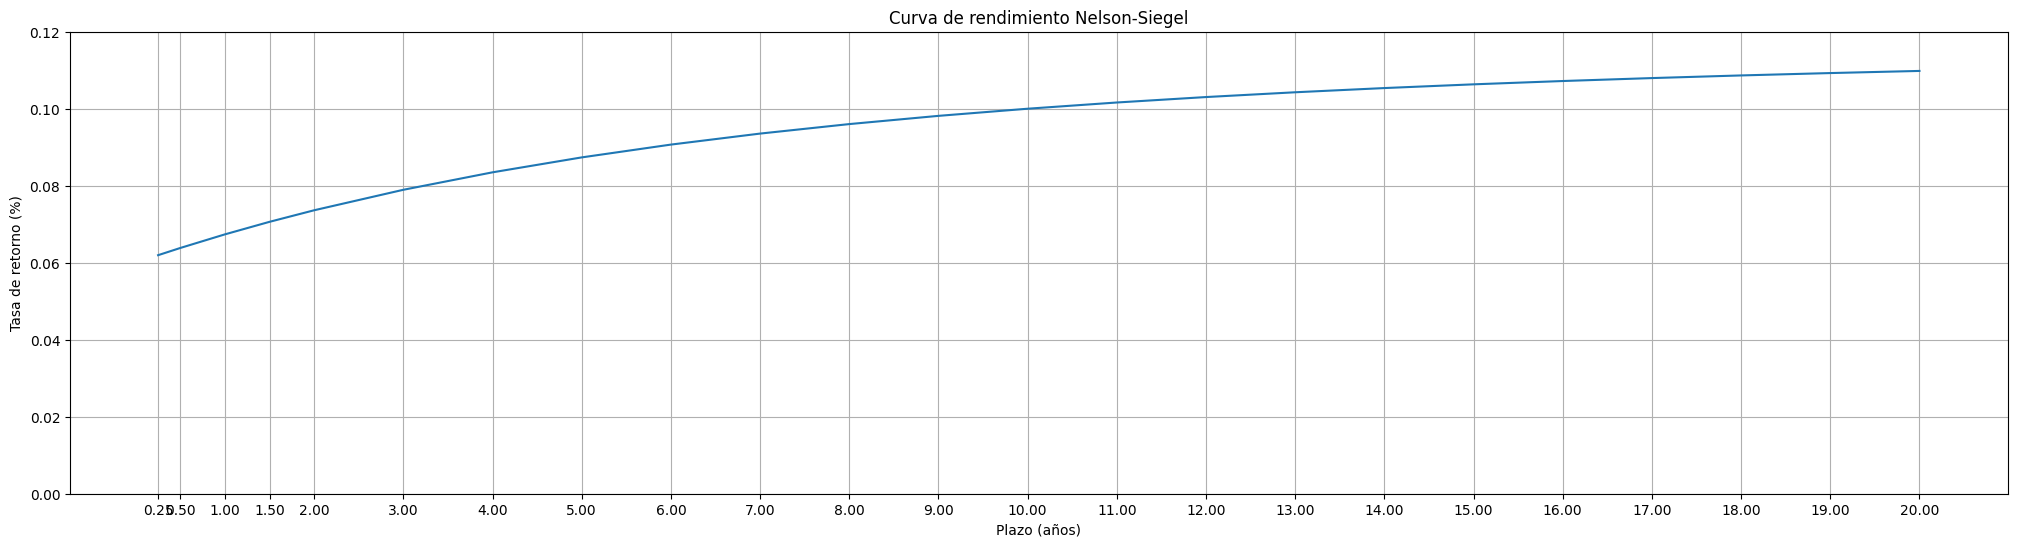

In [ ]:
# Tasas de descuento con el modelo Nelson-Siegel

parametros = [0.12, -0.06, 0.02, 0.2]   # Parametros simulados
Bono_a.Nelson_Siegel('2023-09-25', parametros, None)

In [ ]:
# Valoracion del bono y calculo de metricas
Metrics = Bono_a.valoracion('2023-09-25',parametros)
print('\nValoracion - Metricas: ')
Metrics

Fecha de valoración 2023-09-25
Tasa para el plazo -0.8657534246575342 : 5.25%
Fecha de valoración 2023-09-25
Tasa para el plazo -0.3643835616438356 : 5.70%
Fecha de valoración 2023-09-25
Tasa para el plazo 0.13424657534246576 : 6.11%
Fecha de valoración 2023-09-25
Tasa para el plazo 0.6356164383561644 : 6.48%
Fecha de valoración 2023-09-25
Tasa para el plazo 1.1342465753424658 : 6.83%
Fecha de valoración 2023-09-25
Tasa para el plazo 1.6383561643835616 : 7.15%

Valoracion - Metricas: 


{'Precio_sucio': 117608.45012484874,
 'Precio_limpio': 112127.6808940795,
 'Intereses_Causados': 5480.7692307692305,
 'Tasa_Rendimiento': 0.07109248765474009,
 'Duracion_Modicifada': 1.355966407428108,
 'Convexidad': 384065.7745072193,
 'Suma_pagos': 130000.0}

In [ ]:
parametros2 = [0.122, -0.055, 0.02, 0.2]
# Retorno por haber tenido el bono
Valor = Bono_a.retorno('2023-09-25', '2024-04-10', parametros, parametros2)
print('\nValoracion: ')
Valor

Fecha de valoración 2024-04-10 00:00:00
Tasa para el plazo -1.4082191780821918 : 5.51%
Fecha de valoración 2024-04-10 00:00:00
Tasa para el plazo -0.9068493150684932 : 5.96%
Fecha de valoración 2024-04-10 00:00:00
Tasa para el plazo -0.40821917808219177 : 6.38%
Fecha de valoración 2024-04-10 00:00:00
Tasa para el plazo 0.09315068493150686 : 6.77%
Fecha de valoración 2024-04-10 00:00:00
Tasa para el plazo 0.5917808219178082 : 7.12%
Fecha de valoración 2024-04-10 00:00:00
Tasa para el plazo 1.095890410958904 : 7.45%
Fecha de valoración 2023-09-25
Tasa para el plazo -0.8657534246575342 : 5.25%
Fecha de valoración 2023-09-25
Tasa para el plazo -0.3643835616438356 : 5.70%
Fecha de valoración 2023-09-25
Tasa para el plazo 0.13424657534246576 : 6.11%
Fecha de valoración 2023-09-25
Tasa para el plazo 0.6356164383561644 : 6.48%
Fecha de valoración 2023-09-25
Tasa para el plazo 1.1342465753424658 : 6.83%
Fecha de valoración 2023-09-25
Tasa para el plazo 1.6383561643835616 : 7.15%

Valoracion: 


{'Precio_sucio': 114014.03981604628,
 'Tasa de Rendimiento': '7.43%',
 'Holding Period return': 0.03320841051005702,
 'Holding Period return anual': 0.062073376970894545}